# Fine-tuning a BERT model for text extraction with the SQuAD dataset

We are going to fine-tune BERT for the text-extraction task with a dataset of questions and answers. The question are about a give paragraph (*context*) that contains the answers. The model will be trained to locate the answer in the context by giving the possitions where the answer starts and finishes.

This notebook is based on [BERT (from HuggingFace Transformers) for Text Extraction](https://keras.io/examples/nlp/text_extraction_with_bert/).

 More info:
  * [The Illustrated Transformer](https://jalammar.github.io/illustrated-transformer/)

In [1]:
import os
import json
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import dataset_utils as du
from tokenizers import BertWordPieceTokenizer
from transformers import TFBertModel, BertTokenizer


batch_size = 16
max_len = 384

In [2]:
slow_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased",
                                               cache_dir=f"/scratch/snx3000/stud50/_bert_tockenizer")

save_path = f"/scratch/snx3000/stud50/bert_tockenizer"
if not os.path.exists(save_path):
    os.makedirs(save_path)
    slow_tokenizer.save_pretrained(save_path)

# Load the fast tokenizer from saved file
tokenizer = BertWordPieceTokenizer(f"{save_path}/vocab.txt", lowercase=True)

In [3]:
train_data_url = "https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v1.1.json"
eval_data_url = "https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v1.1.json"
train_path = keras.utils.get_file("train.json", train_data_url, cache_dir="./")
eval_path = keras.utils.get_file("eval.json", eval_data_url, cache_dir="./")

In [4]:
with open(train_path) as f:
    raw_train_data = json.load(f)

with open(eval_path) as f:
    raw_eval_data = json.load(f)

print(f"{len(raw_train_data['data'])} training items loaded.")
print(f"{len(raw_eval_data['data'])} evaluation items loaded.")

442 training items loaded.
48 evaluation items loaded.


In [5]:
%%time

train_squad_examples = du.create_squad_examples(raw_train_data, max_len, tokenizer)
x_train, y_train = du.create_inputs_targets(train_squad_examples, shuffle=True, seed=42)
print(f"{len(train_squad_examples)} training points created.")

eval_squad_examples = du.create_squad_examples(raw_eval_data, max_len, tokenizer)
x_eval, y_eval = du.create_inputs_targets(eval_squad_examples)
print(f"{len(eval_squad_examples)} evaluation points created.")

86136 training points created.
10331 evaluation points created.
CPU times: user 55.2 s, sys: 1.34 s, total: 56.6 s
Wall time: 56.6 s


In [6]:
encoder = TFBertModel.from_pretrained("bert-base-uncased",
                                      cache_dir=f"/scratch/snx3000/stud50/bert_model")

input_ids = layers.Input(shape=(max_len,), dtype=tf.int32)
token_type_ids = layers.Input(shape=(max_len,), dtype=tf.int32)
attention_mask = layers.Input(shape=(max_len,), dtype=tf.int32)

embedding = encoder(input_ids,
                    token_type_ids=token_type_ids,
                    attention_mask=attention_mask)[0]

start_logits = layers.Dense(1, name="start_logit", use_bias=False)(embedding)
start_logits = layers.Flatten()(start_logits)
start_probs = layers.Activation(keras.activations.softmax)(start_logits)

end_logits = layers.Dense(1, name="end_logit", use_bias=False)(embedding)
end_logits = layers.Flatten()(end_logits)
end_probs = layers.Activation(keras.activations.softmax)(end_logits)

model = keras.Model(inputs=[input_ids, token_type_ids, attention_mask],
                    outputs=[start_probs, end_probs])

loss = keras.losses.SparseCategoricalCrossentropy(from_logits=False)
optimizer = keras.optimizers.Adam(lr=5e-5)

model.compile(optimizer=optimizer, loss=[loss, loss])

Some weights of the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the ckeckpoint was trained on, you can already use TFBertModel for predictions without further training.


In [7]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 384)]        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 384)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 384)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     ((None, 384, 768), ( 109482240   input_1[0][0]                    
                                                                 input_3[0][0]         

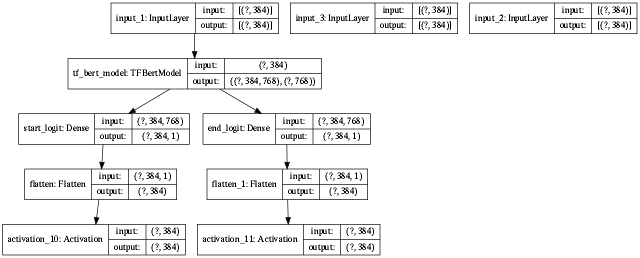

In [8]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=48)

In [9]:
def get_dataset(x, y, batch_size=batch_size):
    dataset = tf.data.Dataset.zip((
        tf.data.Dataset.from_tensor_slices(x),
        tf.data.Dataset.from_tensor_slices(y),
    ))
    dataset = dataset.shuffle(2048, seed=42)
    dataset = dataset.repeat()
    dataset = dataset.batch(batch_size)
    return dataset

# batch shapes
for X, Y in get_dataset(x_train, y_train).take(1):
    print([i.shape for i in X],
          [i.shape for i in Y])

[TensorShape([16, 384]), TensorShape([16, 384]), TensorShape([16, 384])] [TensorShape([16]), TensorShape([16])]


In [10]:
# def dataset_generator(x, y):
#     for i in range(x[0].shape[0]):
#         yield ((x[0][i], x[1][i], x[2][i]),
#                (y[0][i], y[1][i]))

# def get_generator(x, y, batch_size=batch_size, output_shapes=(((max_len,), (max_len,), (max_len,)),((), ()))):
#     dataset = tf.data.Dataset.from_generator(lambda: dataset_generator(x, y),
#                                              output_types=((tf.int32, tf.int32, tf.int32),(tf.int32, tf.int32)),
#                                              output_shapes=output_shapes)
#     dataset = dataset.shuffle(2048, seed=42)
#     dataset = dataset.repeat()
#     dataset = dataset.batch(batch_size)
#     return dataset

# # batch shapes
# for X, Y in get_generator(x_train, y_train).take(1):
#     print([i.shape for i in X],
#           [i.shape for i in Y])

In [11]:
fit = model.fit(get_dataset(x_train, y_train),
                epochs=1,
                steps_per_epoch=50,
                validation_data=get_dataset(x_eval, y_eval),
                validation_steps=len(y_eval[0]) // batch_size)

50/50 [==============================] - 203s 4s/step - loss: 7.2170 - activation_10_loss: 3.7391 - activation_11_loss: 3.4779 - val_loss: 4.9895 - val_activation_10_loss: 2.5864 - val_activation_11_loss: 2.4031


In [12]:
# model.save_weights(f"{os.environ['SCRATCH']}/bert_model_tuned.h5")

### Evaluation

In [13]:
# model.evaluate(x_eval, y_eval)

In [14]:
import string
import re


def normalize_text(text):
    text = text.lower()

    # Remove punctuations
    exclude = set(string.punctuation)
    text = "".join(ch for ch in text if ch not in exclude)

    # Remove articles
    regex = re.compile(r"\b(a|an|the)\b", re.UNICODE)
    text = re.sub(regex, " ", text)

    # Remove extra white space
    text = " ".join(text.split())
    return text


class ExactMatch():
    """
    Each `SquadExample` object contains the character level offsets for each token
    in its input paragraph. We use them to get back the span of text corresponding
    to the tokens between our predicted start and end tokens.
    All the ground-truth answers are also present in each `SquadExample` object.
    We calculate the percentage of data points where the span of text obtained
    from model predictions matches one of the ground-truth answers.
    """

    def __init__(self, x_eval, y_eval, model, squad_examples):
        self.x_eval = x_eval
        self.y_eval = y_eval
        self.model = model
        self.squad_examples = squad_examples

    def score(self, logs=None):
        pred_start, pred_end = self.model.predict(self.x_eval)
        count = 0
        eval_examples_no_skip = [_ for _ in self.squad_examples if _.skip == False]
        for idx, (start, end) in enumerate(zip(pred_start, pred_end)):
            squad_eg = eval_examples_no_skip[idx]
            offsets = squad_eg.context_token_to_char
            start = np.argmax(start)
            end = np.argmax(end)
            if start >= len(offsets):
                continue

            pred_char_start = offsets[start][0]
            if end < len(offsets):
                pred_char_end = offsets[end][1]
                pred_ans = squad_eg.context[pred_char_start:pred_char_end]
            else:
                pred_ans = squad_eg.context[pred_char_start:]

            normalized_pred_ans = normalize_text(pred_ans)
            normalized_true_ans = [normalize_text(_) for _ in squad_eg.all_answers]
            if normalized_pred_ans in normalized_true_ans:
                count += 1
                
            print(f'  - {normalized_pred_ans:30.30s} | ref: {squad_eg.answer_text:30s} | {squad_eg.question}')

        acc = count / len(self.y_eval[0])
        return acc

In [15]:
samples = np.random.choice(len(x_eval[0]), 50, replace=False)

em = ExactMatch([x_eval[0][samples], x_eval[1][samples], x_eval[2][samples]],
                [y_eval[0][samples], y_eval[1][samples]],
                model,
                eval_squad_examples[samples])
em.score()

  - 1870 to 1939                   | ref: 1870 to 1939                   | How long was the Summer Theatre in operation?
  - buying property and building   | ref: extra-legal                    | Excessive bureaucratic red tape is one of the reasons for what type of ownership?
  - paramount pictures             | ref: Paramount Pictures             | What company did Eisner become president of when he left ABC in 1976?
  - 300 km                         | ref: 300 km long                    | How long is the Upper Rhine Plain?
  - 1346 and 1671                  | ref: the plague was present somewhere in Europe in every year between 1346 and 1671. | What did Biraben say about the plague in Europe?
  - luna 180foot 55 mtall 600yearo | ref: 738 days                       | How long did Julia Butterfly Hill live in a tree?
  - elder brother alexander i had  | ref: Sybilla of Normandy            | Who did Alexander I marry?
  - tesla went on to pursue his id | ref: boat                     

0.2

### Model structure from PyTorch

In [16]:
# !pip install --user torch
from transformers.modeling_bert import BertModel
BertModel.from_pretrained("bert-base-uncased", cache_dir=os.environ['SCRATCH']+'/bert_model')

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          